In [1]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import functools
import os
import time

In [2]:
print(tf.__version__)

2.3.0


In [3]:
try:
    import tensorflow_hub as hub
except ImportError:
    !pip install tensorflow-hub
    import tensorflow_hub as hub
try:
    import tensorflow_datasets as tfds
except ImportError:
    !pip install tensorflow-datasets 
    import tensorflow_datasets as tfds
    
try:
    import matplotlib.pyplot as plt
    from matplotlib import gridspec
except ImportError:
    !pip install matplotlib
    import matplotlib.pyplot as plt
    from matplotlib import gridspec

In [4]:
IMG_HEIGHT,IMG_WIDTH,IMG_CHANNELS, NUM_CLASSES = 32,32,3,10
NUM_AUGMENTATIONS = 10
NUM_AVAILABLE_TEXTURES = 50
style_img_size = (256, 256)

In [5]:
@tfds.decode.make_decoder()
def style_preprocessing_decoder(serialized_image, feature):
    target_height, target_width = style_img_size[0], style_img_size[1]
    serialized_image = tf.io.decode_png(serialized_image)
    serialized_image = tf.image.resize_with_crop_or_pad(serialized_image, target_height, target_width)
    serialized_image = tf.cast(serialized_image, tf.float32)
    return serialized_image / 255.0

@tfds.decode.make_decoder()
def content_preprocessing_decoder(serialized_image, feature):
    serialized_image = tf.io.decode_png(serialized_image)
    serialized_image = tf.cast(serialized_image, tf.float32)
    return serialized_image / 255.0

In [6]:
# Load cifar dataset
cifar_train = tfds.load("cifar10",batch_size=-1, split='train',decoders={'image': content_preprocessing_decoder(),})
cifar_test = tfds.load("cifar10",batch_size=-1, split='test',decoders={'image': content_preprocessing_decoder()})

In [7]:
cifar_train['label'] = tf.one_hot(cifar_train['label'], NUM_CLASSES)
cifar_test['label'] = tf.one_hot(cifar_test['label'], NUM_CLASSES)

In [8]:
cifar_builder = tfds.builder("cifar10")
cifar_builder.download_and_prepare()
cifar_train_ds = cifar_builder.as_dataset(split="train", decoders={'image': content_preprocessing_decoder(),})
cifar_test_ds = cifar_builder.as_dataset(split="test", decoders={'image': content_preprocessing_decoder()})

In [ ]:
style_dataset = tfds.load('dtd',  batch_size=NUM_AVAILABLE_TEXTURES, split='train', decoders={'image': style_preprocessing_decoder(),})
styles = style_dataset.__iter__().get_next()['image']

c:\users\tarun\.conda\envs\tarun\lib\site-packages\urllib3\connectionpool.py:858: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)


In [13]:
# NOTE: if above throws NonMatchingChecksumError then download offline and rerun above snippet

# !python -m tensorflow_datasets.scripts.download_and_prepare --register_checksums=True --datasets='dtd'

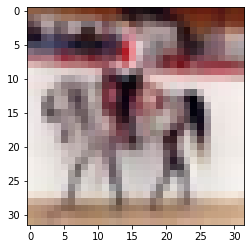

Label: tf.Tensor([0. 0. 0. 0. 0. 0. 0. 1. 0. 0.], shape=(10,), dtype=float32)


In [12]:
# try visualizing the dataset and labels
for idx, cifar_example in enumerate(cifar_train['image']):
    plt.imshow(cifar_example)
    plt.show()
    print("Label:",cifar_train['label'][idx])
    break

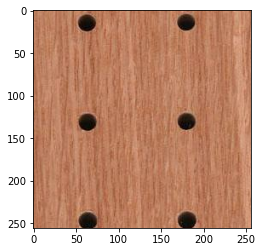

In [15]:
# try visualizing the style
for style_example in styles:
    plt.imshow(style_example)
    plt.show()
    break

In [13]:
# Load image stylization module.
hub_module = hub.load('style_transfer_content_weights_params')

In [15]:
hub_module

'1.15.0'

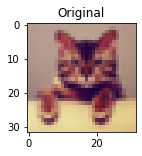

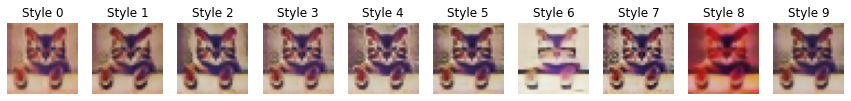

In [22]:
# Stylize image.

custom_ratio = 0.7  # change ratio here; higher ratio -- more content; lesser ratio - more style

content_image = cifar_train['image'][0]
fig = plt.figure(figsize=(2,2))
plt.title('Original')
plt.imshow(content_image)
plt.show()
content_image = tf.image.resize(content_image, style_img_size)  # need to resize to 256 as expected by style network

fig = plt.figure(figsize=(15,15))
for style_idx in range(10):
    fig.add_subplot(1, 10, style_idx+1)
    style_image = styles[style_idx]
    outputs = hub_module(tf.convert_to_tensor(content_image.numpy()[np.newaxis, ...]), 
                tf.convert_to_tensor(style_image.numpy()[np.newaxis, ...]), tf.convert_to_tensor(custom_ratio))
    stylized_image = outputs[0]
    plt.imshow(tf.image.resize(stylized_image[0], (32,32)))  # resize back to suit dataset size
    plt.axis('off')
    plt.title('Style {}'.format(style_idx))
plt.show()